# Optimization Methods Project Work: SMO and DCD-Linear for training SVM

This notebook will contain some code that implements the SMO and DCD-Linear algorithm, plus the results.

## Testing the environment

The following cell will simply verify if all the libraries necessary to run the code are correctly installed.

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math
import random
import time
import os
import json
import pandas as pd
from numpy.linalg import norm
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import dump_svmlight_file
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random.seed(91212) # This function allows to replicate the same experiemtns even if the random function is used

print("Everything is good!")

In [ ]:
def load_dataset(name: str, dimension = None, features = None):
    bias = load_svmlight_file(name)
    bias = (bias[0].toarray(), bias[1])

    if(dimension is not None):
        permutation = np.random.permutation(bias[0].shape[0])

        indexs = permutation[0:dimension]
        bias = (bias[0][indexs], bias[1][indexs])

    if features is not None:
        bias = (bias[0][:, features], bias[1])
    
    new_column = np.atleast_2d(np.ones(bias[0].shape[0])).T
    unbias = (np.hstack([bias[0], new_column]), bias[1])

    return (bias, unbias)
    
def feature_extractor(feature_num: int, original_num: int):
    permutation = np.random.permutation(original_num)
    return np.sort(permutation[0:feature_num])

## Defining the Dual Problem

### The Bias One (For SMO)

As we know, the formulation of the dual problem for training a SVM is:
$$
\begin{gather*}
\min_{\alpha} \frac{1}{2}\alpha^TQ\alpha - e^T\alpha \\
\forall i\ 0 \leq \alpha_i \leq C\ \ \sum \limits_i^n \alpha_iy_i = 0
\end{gather*}
$$

As stated in the Project Goals, we will use the Most Violating Pair rule to select the variables to change. So, to implement this algorithm efficiently, we need those elements:
* A function that calculates the derivatives
* A function that adjust the derivative after changing $\alpha$ 
* A function that extract the most violating pair.

To sum up all this functionality, they will be implemented inside a class. The constructor will receive the set of Xs and Ys, and using that will derive Q.

In [ ]:
class DualSVMProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5, sparse = False):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(self.a)
        self.epsilon = epsilon
        self.sparse = sparse

        if sparse:
            self.calculated = [False] * self.Y.shape[0]
            self.Q = {}
        else:
            mat = np.stack([Ys.T] * Xs.shape[1], axis = 1)
            
            Z = Xs * mat
            self.Q = Z @ Z.T
        
        self.d = - self.e

    def getA(self):
        return self.a
        
    def getDerivative(self):
        return self.d    

    def getMostViolatingPair(self):
        
        directions = self.d / self.Y
        min_idx = -1
        min_value = np.inf
        max_idx = -1
        max_value = -np.inf
        
        R = directions.copy()
        R[np.logical_and(self.a < self.epsilon, self.Y == -1)] = np.inf
        R[np.logical_and(self.a > (self.C - self.epsilon), self.Y == 1)] = np.inf

        S = directions.copy()
        S[np.logical_and(self.a < self.epsilon, self.Y == 1)] = -np.inf
        S[np.logical_and(self.a > (self.C - self.epsilon), self.Y == -1)] = -np.inf

        min_idx = np.argmin(R)
        max_idx = np.argmax(S)

        if R[min_idx] == np.inf or S[max_idx] == -np.inf:
            return None
                
        return (min_idx, max_idx)

    def updateA(self, idx1, a1, idx2, a2):

        if self.sparse:
            self.d = self.getQColumn(idx1) * (a1 - self.a[idx1]) + self.getQColumn(idx2) * (a2 - self.a[idx2]) + self.d
        else:
            self.d = self.Q[idx1] * (a1 - self.a[idx1]) + self.Q[idx2] * (a2 - self.a[idx2]) + self.d
        
        self.a[idx1] = a1
        self.a[idx2] = a2

    def getParameters(self):
        mat = np.stack([self.a.T * self.Y.T] * self.X.shape[1], axis = 1)
        w = np.sum(mat * self.X, axis = 0)
        b = 0
        for i in range(len(self.a)):
            if(self.a[i] < self.epsilon or self.a[i] > self.C - self.epsilon):
                continue
            b = 1 / self.Y[i] - w @ self.X[i]
            break        
        return (w, b)

    def getQColumn(self, i):
        if self.sparse:
            if not self.calculated[i]:
                self.Q[i] = self.Y[i] * (self.Y * (self.X @ self.X[i]))
                self.calculated[i] = True
        return self.Q[i]
        

class SVM:
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def __call__(self, x):
        return np.sign(x @ self.w + self.b)

def dual_loss_svm(a, Q):
    return 0.5 * (a.T @ Q @ a) - np.sum(a)

def loss_svm_obj(svm, C, X, y):
    return loss_svm(svm.w, svm.b, C, X, y)
    
def loss_svm(w, b, C, X, y):
    psi = np.maximum(np.zeros_like(y), np.ones_like(y) - y * (X @ w + np.ones_like(y) * b))
    return 0.5 * (w.T @ w) + C * np.sum(psi)

In [ ]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

# The safe way to calculate matrix Q
Q = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        Q[i][j] = Y[i] * Y[j] * X[i] @ X[j]

problem = DualSVMProblem(X, Y, C)

ok = True
    
if ((np.array([-1, -1]) != problem.getDerivative()).all()):
    ok = False
    print("The derivative function if wrong")

update = np.array([1, 2])
problem.updateA(0, update[0], 1, update[1])

if (norm(Q[0] - problem.getQColumn(0)) > 1e-3 or norm(Q[1] - problem.getQColumn(1)) > 1e-3):
    ok = False
    print("The matix calculation is wrong")
    
if ((Q @ update - np.ones(2) != problem.getDerivative()).all()):
    ok = False
    print("The updates of variables doesn't update the derivative in the right way")

elements = problem.getDerivative() / Y

if not (problem.getMostViolatingPair()[0] == (0 if elements[0] < elements[1] else 1) and problem.getMostViolatingPair()[1] == (0 if elements[0] > elements[1] else 1)):
    ok = False
    print("The calculation of the most violating pair is wrong")
    # This test is a bit odd and not exaustive, but can help

if ok:
    print("Everything is working as expected!")

## Implementation of SMO

After implementing core elements for the SMO algorithm, it's time to get them together and build the actual result.
In this implementation, I realized a function that execute a single iteration of the algorithm, leaving the check of convergence outside. The objective is to reuse the external function with the different approach (DCD-Linear), and then make easier to instrument the code to measure some components like loss, validation, etc.

In [ ]:
from typing import Callable
def trainingSMO(problem: DualSVMProblem, step: Callable[[DualSVMProblem], bool], loss_func: Callable[[None], float] = None, validation_func: Callable[[None], float] = None, epsilon = 1e-5, verbose = False):
    loss = []
    validation = []
    
    while(True): 
        (min_idx, max_idx) = problem.getMostViolatingPair()
        elements = problem.getDerivative() / problem.Y

        if verbose:
            print(f"Stopping condition: {elements[max_idx] - elements[min_idx]}")
        if(elements[min_idx] + epsilon > elements[max_idx]):
            break
        
        result = step(problem)            
        (w, b) = problem.getParameters()
        svm = SVM(w, b)
        
        if(loss_func is not None):
            loss.append(loss_func())
    
        if(validation_func is not None):
            validation.append(validation_func())

        if not result:
            # If the step method give False as a result indicates an error or a stop condition (i.e. having a derivative under the tollerance)
            break

    return (loss, validation)

def SMO_step(problem: DualSVMProblem, epsilon: float = 1e-5):
    test = problem.getMostViolatingPair()
    if(test is None):
        raise Exception("The problem did not give a valid violating pair")
    (min_idx, max_idx) = (test[0], test[1])

    direction = np.zeros_like(problem.a)
    direction[min_idx] = 1 * problem.Y[min_idx]
    direction[max_idx] = - 1 * problem.Y[max_idx] #In theory I should divide, but y is in {-1, 1} making the multiplication equivalent, but more efficient

    derivative = problem.getDerivative()

    b = problem.C - problem.a[min_idx] if direction[min_idx] > 0 else problem.a[min_idx]
    b = min(b, problem.C - problem.a[max_idx] if direction[max_idx] > 0 else problem.a[max_idx])
    
    if b < epsilon:
        return False

    tmp = problem.getQColumn(min_idx) * problem.Y[min_idx] - problem.getQColumn(max_idx) * problem.Y[max_idx]   
    value = direction.T @ tmp

    if value > epsilon:
        b = min(b, -(derivative.T @ direction) / value)

    problem.updateA(min_idx, problem.a[min_idx] + b * direction[min_idx], max_idx, problem.a[max_idx] + b * direction[max_idx])
    return True    

## Testing the Code

In the following cells, I will use a very simple classification problem to see if the code works at all. [This dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#breast-cancer) is composed by only 683 elements, everyone of only 10 features. This dataset is chosen dues to it contained dimension. In fact, this implementation of the Dual SVM explicitly calculate the Q matrix, something that can become prohibitive very quickly in the increase of elements.

In [ ]:
(Xs, Ys) = load_svmlight_file("datasets/breast_cancer_scale")
Ys[Ys == 2] = 1
Ys[Ys == 4] = -1 # TODO control the description to decide what is positive and what is negative

Xs = Xs.toarray()

Xs 

dump_svmlight_file(Xs, Ys, "datasets/breast_cancer_ones")

# There is a lot to say (Xs originally is a sparce matrix, not scaled values broke the model, Ys classes are 2 and 4)

In [ ]:
(train_Xs, test_Xs, train_Ys, test_Ys)  = train_test_split(Xs, Ys, test_size = 0.20)

base_svm = LinearSVC(C = 10)
base_svm.fit(train_Xs, train_Ys)

train_preds = base_svm.predict(train_Xs)
test_preds = base_svm.predict(test_Xs)


print("Report on train set:")
print(classification_report(train_Ys, train_preds, zero_division = 0))

print("Report on test set:")
print(classification_report(test_Ys, test_preds, zero_division = 0))

In [ ]:
base_smo_problem = DualSVMProblem(train_Xs, train_Ys, C = 10)

(_, _) = trainingSMO(base_smo_problem, SMO_step, epsilon = 1e-2)

(w, b) = base_smo_problem.getParameters()
smo_svm = SVM(w, b)
smo_train_preds = smo_svm(train_Xs)
smo_test_preds = smo_svm(test_Xs)

print("Result of the model trained using SMO on training set:")
print(classification_report(train_Ys, smo_train_preds, zero_division=0))

print("Result of the model trained using SMO on test set:")
print(classification_report(test_Ys, smo_test_preds, zero_division=0))

In [ ]:
print(f"Difference in norm of w: {norm(w - base_svm.coef_)}")
print(f'"Correlation" between the direction of ws : {(w.T @ base_svm.coef_[0]) / (norm(w) * norm(base_svm.coef_))}')
print(f"Difference in the value b: {abs(b - base_svm.intercept_)}")

## Verifying if the sparse implementation gives some benefits

In [ ]:
(A, B) = load_dataset("datasets/a2a")

start_time = time.time()
unsparse_smo_problem = DualSVMProblem(A[0], A[1], C = 1)
(_, _) = trainingSMO(unsparse_smo_problem, SMO_step, epsilon = 1e-2)
time_taken = time.time() - start_time
print(f"Time Taken by the base method: {time_taken}")

In [ ]:
start_time = time.time()
sparse_smo_problem = DualSVMProblem(A[0], A[1], C = 1, sparse = True)
(_, _) = trainingSMO(sparse_smo_problem, SMO_step, epsilon = 1e-2)
time_taken = time.time() - start_time
print(f"Time Taken by the sparce method: {time_taken}")

## DCD Linear

After implementing the SMO algorithm, now it's time to implement the DCD version. To maintain the uniformity in the problem definition, I will implement the dual formulation of the L1-SVM problem. 

In [ ]:
class DCDDualProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(Ys)
        self.diagQ = np.pow(np.sum(np.pow(Xs, 2), axis = 1, dtype = float), -1) #Inverse Diagonal of Q

        self.w = np.zeros(Xs.shape[1], dtype = float)

        self.epsilon = epsilon

    def optimizeOver(self, index):
        G = self.Y[index] * self.w.T @ self.X[index] - 1

        if self.a[index] < self.epsilon:
            PG = min(G, 0)
        elif self.a[index] > self.C - self.epsilon:
            PG = max(G, 0)
        else:
            PG = G

        if abs(PG) < self.epsilon:
            return

        new_a = min(max(self.a[index] - G * self.diagQ[index], 0), self.C) #Notice that during initialization of the class diagQ is already inverted. In this way the code should be more efficient
        self.w = self.w + (new_a - self.a[index]) * self.Y[index] * self.X[index]
        self.a[index] = new_a

    def getProjectedDerivative(self):
        derivative = self.Y * (self.X @ self.w) - self.e
        derivative[np.logical_and(self.a < self.epsilon, derivative > -self.epsilon)] = 0
        derivative[np.logical_and(self.a > C - self.epsilon, derivative < self.epsilon)] = 0
        return derivative

    def getParameters(self):
        return self.w


### Performing some tests

In [ ]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

diagQ = np.array([1 / (X[0].T @ X[0]), 1 / (X[1].T @ X[1])])

problem = DCDDualProblem(X, Y, C)

ok = True
if (not (diagQ == problem.diagQ).all()):
    ok = False
    print("The diagonal of the matix is wrong")

if (not (-np.ones(2) == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (in the initial state)")

problem.optimizeOver(0)

if (not (np.array([1 / 14, 0]) == problem.a).all()):
    ok = False
    print("The optimization function doesn't work.")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (not (derivative == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (after update)")

if (norm(np.array([1, 2, 3]) / 14 - problem.w) > 10e-5):
    ok = False
    print(f"The w is wrong {problem.w}")

### Tests on second update
problem.optimizeOver(1)
if (norm(np.array([1, 46 / 77]) / 14 - problem.a) > 1e-5):
    ok = False
    print("The optimization function doesn't work (second update).")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (norm(derivative - problem.getProjectedDerivative()) > 1e-5):
    ok = False
    print("The derivative calcultaion is wrong (second update)")

if ok:
    print("Everything is working as expected!")


### Actual Training

In [ ]:
def trainingDCD(problem: DCDDualProblem, loss_func: Callable[None, float] = None, validation_func: Callable[None, float] = None, epsilon = 10e-5, verbose: bool = False):
    loss = []
    validation = []
    j = 0
    while(norm(problem.getProjectedDerivative()) > epsilon):
        if verbose:
            print(f"Norm:{norm(problem.getProjectedDerivative())}")
        j+=1
        for i in np.random.permutation(len(problem.a)):
            problem.optimizeOver(i)
            w = problem.getParameters()
            svm = SVM(w, 0)
            
            if(loss_func is not None):
                loss.append(loss_func())
        
            if(validation_func is not None):
                validation.append(validation_func())
                
    return (loss, validation)

In [ ]:
explicit_bias_train = np.atleast_2d(np.ones(train_Xs.shape[0])).T
explicit_bias_test = np.atleast_2d(np.ones(test_Xs.shape[0])).T

train_Xs_unbiased = np.hstack([train_Xs, explicit_bias_train])
test_Xs_unbiased = np.hstack([test_Xs, explicit_bias_test])

print(train_Xs_unbiased.shape)

In [ ]:
base_dcd_problem = DCDDualProblem(train_Xs_unbiased, train_Ys, C = 10)

(_, _) = trainingDCD(base_dcd_problem, epsilon = 1e-2)

In [ ]:
w = base_dcd_problem.getParameters()

dcd_svm = SVM(w, 0)
dcd_train_preds = dcd_svm(train_Xs_unbiased)
dcd_test_preds = dcd_svm(test_Xs_unbiased)

print("Result of the model trained using DCD on training set:")
print(classification_report(train_Ys, dcd_train_preds, zero_division=0))

print("Result of the model trained using DCD on test set:")
print(classification_report(test_Ys, dcd_test_preds, zero_division=0))

## Converting a Bigger Dataset

In [ ]:
from scipy import stats

(Xs, Ys) = load_svmlight_file("datasets/madelon")
Xs = Xs.toarray()

(_, minmax, _, _, _, _) = stats.describe(Xs)

median = np.stack([(minmax[0] + minmax[1]) / 2] * Xs.shape[0])
half_interval = np.stack([(minmax[0] - minmax[1]) / 2] * Xs.shape[0])
Xs = (Xs - median) / half_interval

dump_svmlight_file(Xs, Ys, "datasets/madelon_scaled")

## Performing comparative test on speed

In [21]:
def calculate_accuracy(true_y, data, model):
    preds = model(data)
    return classification_report(true_y, preds, zero_division=0, output_dict=True)["accuracy"]

In [38]:
dataset = "covtype_scale"
thresholds = [1e-1, 1e-2, 1e-3, 1e-4]
dimensions = [1000, 2000, 3000, 4000, 5000, 6000]

C = 1
test_size = 0.20

if not os.path.exists("Results"):
    os.mkdir("Results")

In [40]:
import time
import json

smo_results = {}
dcd_results = {}

smo_results["dimension"] = dimensions
dcd_results["dimension"] = dimensions

for d in dimensions:
    (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = dimension)

    (W, X, Y, Z) = train_test_split(bias[0], bias[1], test_size = test_size)
    bias = (W, Y)
    bias_test = (X, Z)
    
    (W, X, Y, D) = train_test_split(unbias[0], unbias[1], test_size = test_size)
    unbias = (W, Y)
    unbias_test = (X, Z)

    smo_results["thresholds"] = thresholds
    smo_results["times"] = []
    smo_results["primal_loss"] = []
    smo_results["dual_loss"] = []
    smo_results["train_accuracy"] = []
    smo_results["test_accuracy"] = []
    
    dcd_results["thresholds"] = thresholds
    dcd_results["times"] = []
    dcd_results["primal_loss"] = []
    dcd_results["dual_loss"] = []
    dcd_results["train_accuracy"] = []
    dcd_results["test_accuracy"] = []
    
    mat = np.stack([bias[1].T] * bias[0].shape[1], axis = 1)    
    Z = bias[0] * mat
    biasQ = Z @ Z.T

    mat = np.stack([unbias[1].T] * unbias[0].shape[1], axis = 1)    
    Z = unbias[0] * mat
    unbiasQ = Z @ Z.T

    for t in thresholds:
        print(f"Dataset: {dataset}", f"\tDimension: {d}", f"\tThreshold: {t}")

        start_time = time.time()
        smo_problem = DualSVMProblem(bias[0], bias[1], C)        
        (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = t)
        smo_time = time.time() - start_time
        
        (w, b) = smo_problem.getParameters()
        svm = SVM(w, b)
        
        smo_results["primal_loss"].append(loss_svm(w, b, C, bias[0], bias[1]))
        smo_results["dual_loss"].append(dual_loss_svm(smo_problem.a, biasQ))
        smo_results["times"].append(smo_time)
        smo_results["train_accuracy"].append(calculate_accuracy(bias[1], bias[0], svm))
        smo_results["test_accuracy"].append(calculate_accuracy(bias_test[1], bias_test[0], svm))
        
        start_time = time.time()
        dcd_problem = DCDDualProblem(unbias[0], unbias[1], C)
        (_, _) = trainingDCD(dcd_problem, epsilon = t)
        dcd_time = time.time() - start_time
        
        w = dcd_problem.getParameters()        
        svm = SVM(w, 0)
        
        dcd_results["primal_loss"].append(loss_svm(w, 0, C, unbias[0], unbias[1]))
        dcd_results["dual_loss"].append(dual_loss_svm(dcd_problem.a, unbiasQ))
        dcd_results["times"].append(dcd_time)
        dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
        dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))

    smo_file = open(f"Results/smo_{d}.json", "w")
    smo_file.write(json.dumps(smo_results, indent = 2))
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_{d}.json", "w")
    dcd_file.write(json.dumps(dcd_results, indent = 2))
    dcd_file.close()
print("Test Finished")       

Dataset: covtype_scale 	Dimension: 1000 	Threshold: 0.1
Dataset: covtype_scale 	Dimension: 1000 	Threshold: 0.01
Dataset: covtype_scale 	Dimension: 1000 	Threshold: 0.001
Dataset: covtype_scale 	Dimension: 1000 	Threshold: 0.0001
Dataset: covtype_scale 	Dimension: 2000 	Threshold: 0.1
Dataset: covtype_scale 	Dimension: 2000 	Threshold: 0.01
Dataset: covtype_scale 	Dimension: 2000 	Threshold: 0.001
Dataset: covtype_scale 	Dimension: 2000 	Threshold: 0.0001
Dataset: covtype_scale 	Dimension: 3000 	Threshold: 0.1
Dataset: covtype_scale 	Dimension: 3000 	Threshold: 0.01
Dataset: covtype_scale 	Dimension: 3000 	Threshold: 0.001
Dataset: covtype_scale 	Dimension: 3000 	Threshold: 0.0001
Dataset: covtype_scale 	Dimension: 4000 	Threshold: 0.1
Dataset: covtype_scale 	Dimension: 4000 	Threshold: 0.01
Dataset: covtype_scale 	Dimension: 4000 	Threshold: 0.001
Dataset: covtype_scale 	Dimension: 4000 	Threshold: 0.0001
Dataset: covtype_scale 	Dimension: 5000 	Threshold: 0.1
Dataset: covtype_scale 	

## Test Over different feature Number

In [18]:
threshold = 1e-3
dataset = "covtype_scale"
original_num = 54
features_num = [20, 30, 40, 54]

dimension = 3000
test_size = 0.20

In [ ]:
print(bias[0].shape)
print(bias[1].shape)

In [32]:
smo_results = {}
smo_results["thresholds"] = threshold
smo_results["features"] = features_num
smo_results["times"] = []
smo_results["primal_loss"] = []
smo_results["dual_loss"] = []
smo_results["train_accuracy"] = []
smo_results["test_accuracy"] = []

dcd_results = {}
dcd_results["thresholds"] = threshold
dcd_results["features"] = features_num
dcd_results["times"] = []
dcd_results["primal_loss"] = []
dcd_results["dual_loss"] = []
dcd_results["train_accuracy"] = []
dcd_results["test_accuracy"] = []

smo_results["dimension"] = dimension
dcd_results["dimension"] = dimension

for f in features_num:
    features = feature_extractor(f, original_num)    
    (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = dimension, features = features)

    (W, X, Y, Z) = train_test_split(bias[0], bias[1], test_size = test_size)
    bias = (W, Y)
    bias_test = (X, Z)
    
    (W, X, Y, Z) = train_test_split(unbias[0], unbias[1], test_size = test_size)
    unbias = (W, Y)
    unbias_test = (X, Z)
    
    mat = np.stack([bias[1].T] * bias[0].shape[1], axis = 1)    
    Z = bias[0] * mat
    biasQ = Z @ Z.T

    mat = np.stack([unbias[1].T] * unbias[0].shape[1], axis = 1)    
    Z = unbias[0] * mat
    unbiasQ = Z @ Z.T
    
    print(f"Dataset: {dataset}",f"\tThreshold: {threshold}", f"\tFeatures {f}")
        
    start_time = time.time()
    smo_problem = DualSVMProblem(bias[0], bias[1], C)        
    (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)
    smo_time = time.time() - start_time
    
    (w, b) = smo_problem.getParameters()
    svm = SVM(w, b)

    smo_results["primal_loss"].append(loss_svm(w, b, C, bias[0], bias[1]))
    smo_results["dual_loss"].append(dual_loss_svm(smo_problem.a, biasQ))
    smo_results["times"].append(smo_time)
    smo_results["train_accuracy"].append(calculate_accuracy(bias[1], bias[0], svm))
    smo_results["test_accuracy"].append(calculate_accuracy(bias_test[1], bias_test[0], svm))
    
    start_time = time.time()
    dcd_problem = DCDDualProblem(unbias[0], unbias[1], C)
    (_, _) = trainingDCD(dcd_problem, epsilon = threshold)
    dcd_time = time.time() - start_time
    
    w = dcd_problem.getParameters()        
    svm = SVM(w, 0)
    
    dcd_results["primal_loss"].append(loss_svm(w, 0, C, unbias[0], unbias[1]))
    dcd_results["dual_loss"].append(dual_loss_svm(dcd_problem.a, unbiasQ))
    dcd_results["times"].append(dcd_time)
    dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
    dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))
    
smo_file = open(f"Results/smo_features.json", "w")
smo_file.write(json.dumps(smo_results, indent = 2))
smo_file.close()

dcd_file = open(f"Results/dcd__features.json", "w")
dcd_file.write(json.dumps(dcd_results, indent = 2))
dcd_file.close()
print("Test Finished")

Dataset: covtype_scale 	Threshold: 0.001 	Features 20


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Results Over Dimension

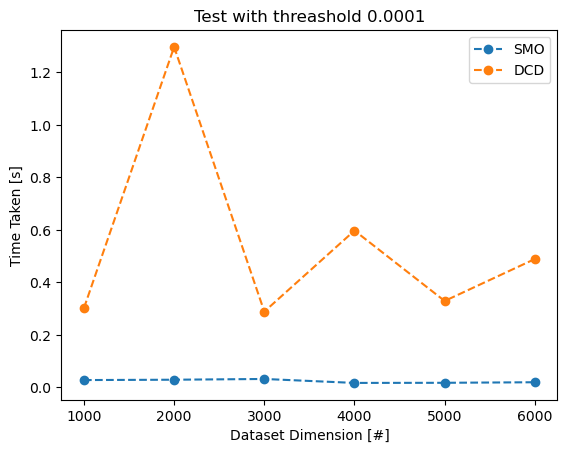

In [41]:
fig, ax = plt.subplots()

smo_dimensions = []
smo_times = []

dcd_dimensions = []
dcd_times = []

index = 3

for d in dimensions:
    smo_file = open(f"Results/smo_{d}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_times.append(smo_results["times"][index])
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_{d}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_times.append(dcd_results["times"][index])
    dcd_file.close()

plt.plot(dimensions, smo_times, label = "SMO", marker='o', linestyle='dashed')
plt.plot(dimensions, dcd_times, label = "DCD", marker='o', linestyle='dashed')

plt.xlabel("Dataset Dimension [#]")
plt.ylabel("Time Taken [s]")
plt.title(f"Test with threashold {smo_results["thresholds"][index]}")

plt.legend()

## Results Over Threshold

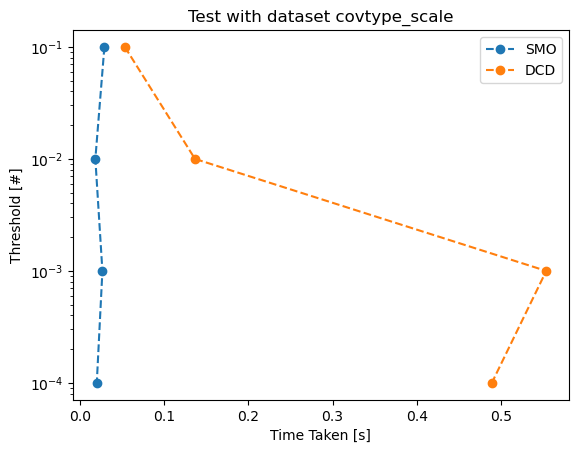

In [43]:
fig, ax = plt.subplots()

dataset = "covtype_scale"
dimension = 6000

smo_file = open(f"Results/smo_{dimension}.json", "r")
smo_results = json.loads(smo_file.read())
smo_file.close()

dcd_file = open(f"Results/dcd_{dimension}.json", "r")
dcd_results = json.loads(dcd_file.read())
dcd_file.close()

plt.plot(smo_results["times"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
plt.plot(dcd_results["times"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')

plt.ylabel("Threshold [#]")
plt.xlabel("Time Taken [s]")
plt.title(f"Test with dataset {dataset}")

ax.set_yscale("log")

plt.legend()

## Results Over Features

In [ ]:
fig, ax = plt.subplots()

dataset = "a3a"

smo_file = open(f"Results/smo_{dataset}_features.json", "r")
smo_results = json.loads(smo_file.read())
smo_file.close()

dcd_file = open(f"Results/dcd_{dataset}_features.json", "r")
dcd_results = json.loads(dcd_file.read())
dcd_file.close()

plt.plot(smo_results["times"], smo_results["features"], label = "SMO", marker='o', linestyle='dashed')
plt.plot(dcd_results["times"], dcd_results["features"], label = "DCD", marker='o', linestyle='dashed')

plt.xlabel("feature Number [#]")
plt.ylabel("Time Taken [s]")
plt.title(f"Test with threashold {smo_results["thresholds"]} and dataset dimension {smo_results["dimensions"]}")

plt.legend()